# 映像(画像)品質評価に関する調査 第2回 SSIM

第1回はディジタル画像の表現方法とMSE/PSNRによる品質評価について触れました。
PSNRはその計算式のシンプルさと画像データの単純な変化量を表す指標として扱いやすいものでしたが、前回の記事で解説したように人間の知覚品質と一致しないケースがあります。

そこで人間の視覚システム(Human Visual System、以下HVS)に近づける画像品質評価のための指標はいくつか提案されてきました。
その中でもWangらによって提案されたSSIM(Structural SIMilarity: 構造的類似度) という指標は、十数年たった今でも最も広く利用されている指標の1つです。

## HVSの特性

SSIMは *Structural SIMilarity (構造的類似度)* という名前の通り、「構造」に着目した品質評価指標です。
まずは構造について理解するために、次の画像に注目してください。

In [11]:
def mse(ref, dis):
    return np.mean((ref - dis) **2)

def psnr(ref, dis):
    pixel_max = 255
    return 20 * math.log10(pixel_max / math.sqrt(mse(ref, dis)))

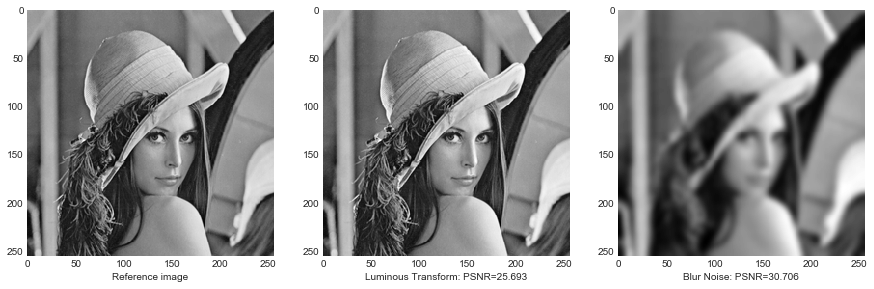

In [20]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

grayscale_luminous_array = np.clip(grayscale_array * 1.1, 0, 255) # Luminous Linear Transform
grayscale_blur_img = grayscale_img.filter(ImageFilter.GaussianBlur(3)) # Gaussian Blur

ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])
ax1.imshow(grayscale_array, cmap='gray')
ax1.set_xlabel("Reference image")
ax2.imshow(grayscale_luminous_array, cmap='gray')
ax2.set_xlabel(f"Luminous Transform: PSNR={psnr(grayscale_array, grayscale_luminous_array):.03f}")
ax3.imshow(grayscale_blur_array, cmap='gray')
ax3.set_xlabel(f"Blur Noise: PSNR={psnr(grayscale_array, grayscale_blur_array):.03f}")
plt.show()

みなさんの目からみると輝度をあげた真ん中の画像はそれほど品質が劣化していないようにみえるかもしれません。
しかしPSNRのスコア上は、ガウシアンブラーを加えてぼかした右の画像のスコアを下ってしまいました。SSIMの提案論文では、この理由を次のように述べています。

*「構造に関する情報が失われる変換を、人間は大きな品質劣化が生じたと認知する」*

画像の中にでてくる物体や模様の輪かくなどの情報がこの「構造」にあたると考えてもらえれば大丈夫です。ガウシアンブラーにより輪郭がぼやけていることで画像の中に描かれている物体の構造が分かりづらくなってくると人間の視覚システムは品質が劣化したように感じます。

グレースケール画像は各ピクセルにその明るさが保持されていますが、画像の中に存在する物体表面の明るさは照明の反射の影響を受けます。つまり物体の構造的な情報を調べるためには、照明の影響を分離する必要があります。

そこでWangらは照明の影響が「画像全体の輝度の平均値」と「コントラスト」で表現できると考え、それらを取り除いた値が「構造」であると定義しました。

## SSIMのシステムダイアグラム

早速ですがSSIM のシステムダイアグラムを次に示します (出展: [Image Quality Assessment: From Error Visibility to
Structural Similarity](https://ieeexplore.ieee.org/document/1284395/), 6ページより)。

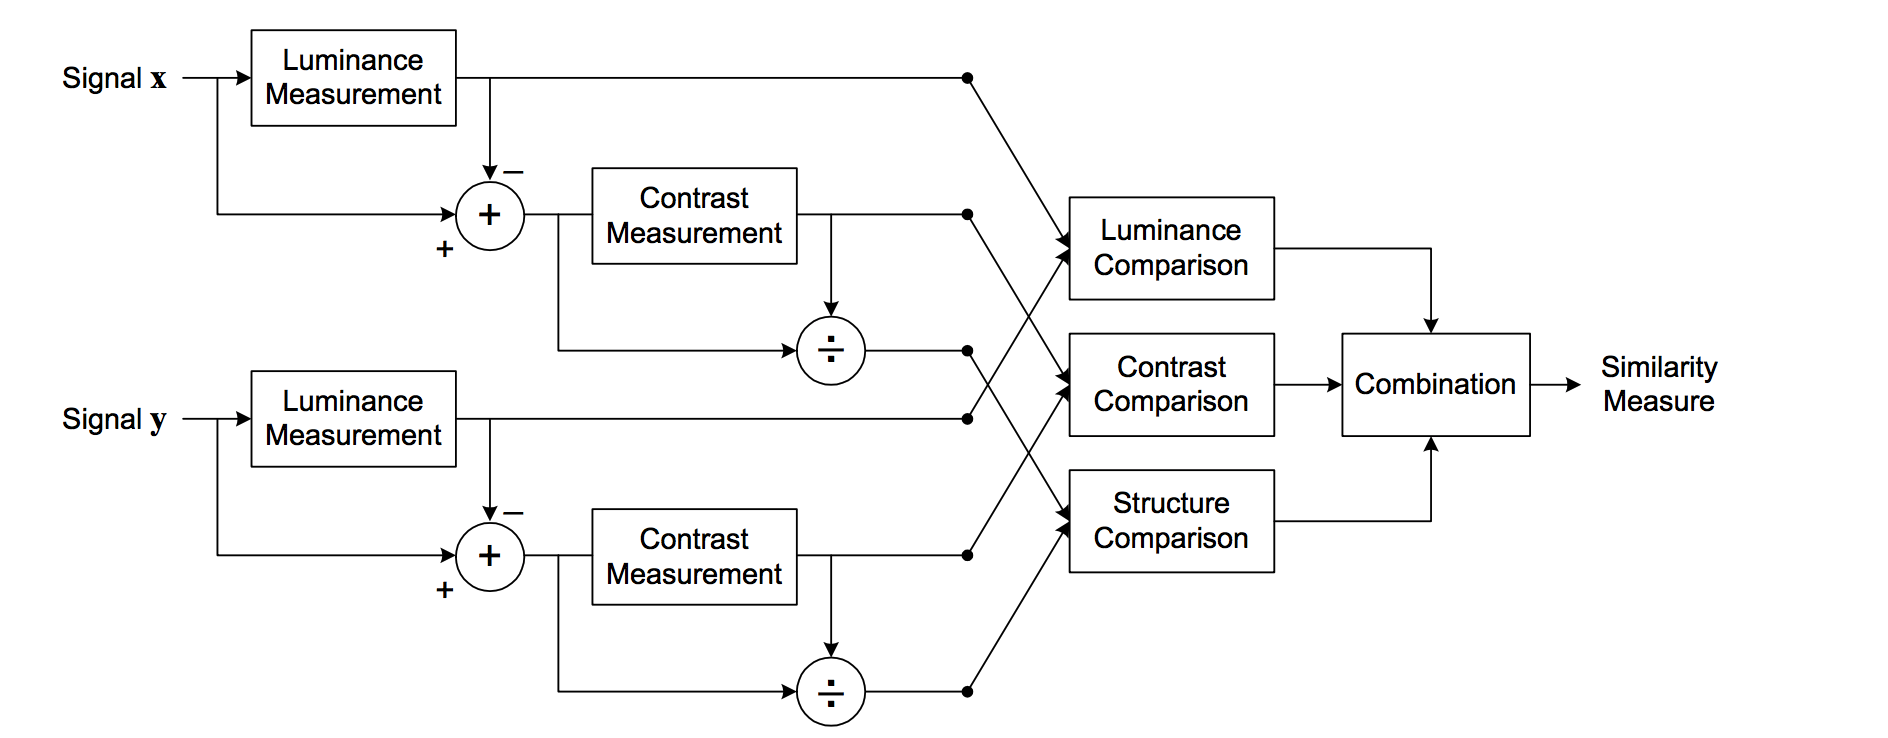

この図は2つの画像(信号 $\boldsymbol{x}$ と信号 $\boldsymbol{y}$)を入力としたときに、それぞれの信号情報を「明るさ」「コントラスト」「構造」の3つの成分に分解し比較していることを示しています。どちらかの入力信号が完璧な品質を持つ画像であると仮定することで、品質劣化が定量的に測定できます。

### 明るさ (Luminous Measurement)

まずは画像全体の明るさを計算します。入力信号 $\boldsymbol{x}$ は離散的な値であるとすると、明るさは次式よりもとまります。

$l(\boldsymbol{x}) = \frac{1}{N} \sum_{i=1}^{N} x_i$

In [22]:
measure_luminance(grayscale_array)

123.54656982421875

In [23]:
measure_luminance(grayscale_luminous_array)

135.90080566406252

### コントラスト (Contrast Measurement)

コントラストは明るさにどれだけばらつきがあるかということなので、入力信号の標本標準偏差で表されます。

$c(\boldsymbol{x}) = (\frac{1}{N-1} \sum_{i=1}^{N} (x_i - \mu_x)^2)^{\frac{1}{2}}$

In [25]:
def measure_contrast(img):
    return np.std(img, ddof=1)

In [26]:
measure_contrast(grayscale_array)

47.63670723861667

In [27]:
measure_contrast(grayscale_luminous_array)

52.399384282831235

### 構造 (Structure Measurement)

先程述べたようにWangらは、照明の影響が「画像全体の輝度の平均値」と「コントラスト」で表現できると考え、それらを取り除いた値が「構造」であると定義しました。これらを取り除くには次式のように入力信号を明るさとコントラストで正規化します。

$s(\boldsymbol{x}) = \frac{\boldsymbol{x} - \mu_x}{\sigma_x}$

In [28]:
def measure_structure(img):
    return (img - measure_luminance(img)) / measure_contrast(img)

In [29]:
measure_structure(grayscale_array)

array([[ 0.80722267,  0.78623046,  0.74424603, ...,  0.97516039,
         0.97516039,  0.36638616],
       [ 0.80722267,  0.80722267,  0.74424603, ...,  1.01714482,
         1.05912925,  0.49233945],
       [ 0.82821489,  0.76523824,  0.74424603, ...,  0.78623046,
         0.57630831, -0.17941143],
       ...,
       [-1.54390541, -1.52291319, -1.50192098, ..., -0.87215453,
        -0.66223238, -0.66223238],
       [-1.64886648, -1.56489762, -1.54390541, ..., -0.64124016,
        -0.47330244, -0.53627909],
       [-1.6698587 , -1.50192098, -1.54390541, ..., -0.49429466,
        -0.43131801, -0.36834137]])

## 評価関数の設計

次はこの3つの値をどのように組み合わせて最終的なSSIMの値とするかを考えていきます。
組み合わせ方はいろいろあるかと思いますが大事なのは、次の3つの特性を持つことです。

1. Symmetry: $S(\boldsymbol{x}, \boldsymbol{y}) = S(\boldsymbol{y}, \boldsymbol{x})$
2. Boundedness: $S(\boldsymbol{x}, \boldsymbol{y}) \le 1$
3. Unique maximum: $S(\boldsymbol{x}, \boldsymbol{y}) =1$ if and only if $\boldsymbol{x} = \boldsymbol{y}$

これは別の表現をすると

1. 2つの入力画像を入れ替えても同じ値をとること
2. 出力値が有界があること。SSIMの最大値は 1 です。
3. 2つの入力信号が同じ場合にのみ、最大値をとること

を表しています。それではSSIMが設計した比較関数について見ていきましょう。

### 明るさの比較 (Luminance Comparison)

入力信号\boldsymbol{x} の \boldsymbol{y}明るさを比較する関数は、ダイナミックレンジ(各ピクセルが取りうる値の範囲) $L$ と小さな定数 $K1 (K1 << 1)$ を導入して次式より求まります。

$l(\boldsymbol{x}, \boldsymbol{y}) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}$, 但し $C_1 = (K_1 L)^2$

それではこの式が先程あげた3つの特性をみたすかどうか確認しましょう。
まずこの式は明らかに $\boldsymbol{x}$ と $\boldsymbol{y}$ を入れ替えても同じ値をとります。
また $\mu_y$ が $\mu_x$ に限りなく近づく際に、分母・分子ともに $2\mu_x^2$ に近づくことからBoundednessの性質とUnique Maximumの性質を満たすことが確認できます。

In [39]:
K1 = 0.01
L = 2**8  # 8 bits grayscale image
C1 = (K1 * L)**2

def compare_luminance(x, y):
    mux = measure_luminance(x)
    muy = measure_luminance(y)
    return (2 * mux * muy + C1) / (mux**2 + muy**2 + C1)

In [40]:
compare_luminance(grayscale_array, grayscale_luminous_array)

0.995476285116536

### コントラストの比較

コントラストの比較も組み立てる式は同じです。こちらも定数 $K2 (K2 << 1)$ を導入し次式より求まります。

$c(\boldsymbol{x}, \boldsymbol{y}) = \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}$

In [44]:
K2 = 0.03
L = 2**8  # 8 bits grayscale image
C2 = (K1 * L)**2

def compare_contrast(x, y):
    mux = measure_contrast(x)
    muy = measure_contrast(y)
    return (2 * mux * muy + C2) / (mux**2 + muy**2 + C2)

In [45]:
compare_contrast(grayscale_array, grayscale_luminous_array)

0.9954828098638867

### 構造の比較

構造の比較では少しアプローチを変えます。
構造は平均値と標本標準偏差により正規化されたベクトル値でした。
このベクトル値の相関を示すために相関係数を導入します。

$s(\boldsymbol{x}, \boldsymbol{y}) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3}$

## まとめと関連研究

今回は [「Image Quality Assessment: From Error Visibility to Structural Similarity (2003)」](https://ieeexplore.ieee.org/document/1284395/)の論文を元に、SSIM Indexの理論を実装を交えて解説しました
Wangらは何度かSSIMに関する提案論文を発表してきましたが、この論文は評価実験のデータセットを増やし理論も一般化したこの論文は多くの文献から参照されています。

一方でこの論文の他にも次のような関連研究が発表されています。

### Multi-scale structural similarity for image quality assessment (2004)
* 著者: Zhou Wang, Eero P. Simoncelli and Alan C. Bovik
* 論文PDF: http://www.cns.nyu.edu/~zwang/files/papers/msssim.pdf
* 概要: ローパスフィルタとダウンサンプリングを繰り返すことで、異なる解像度の画像を用意・比較することで精度をあげる。

### Exact global histogram specification optimized for structural similarity (2008)

* 著者: Alireza Nasiri Avanaki
* arxiv: https://arxiv.org/abs/0901.0065
* 論文PDF: https://slideheaven.com/exact-global-histogram-specification-optimized-for-structural-similarity.html
* 概要: Fast SSIMとかとは違って、高速化ではなく人間の知覚品質にさらに近づけることを目的にしている。
* 実装例: [scikit-image](https://github.com/scikit-image/scikit-image/blob/master/skimage/measure/_structural_similarity.py)

### Understanding and simplifying the structural similarity metric (2008)

* 著者: David M. Rouse, Sheila S. Hemami
* 論文: Understanding and simplifying the structural similarity metric
* メモ: Netflix/VMAFで実装されているMulti Scale SSIM 。必要な乗算処理が20%削減されるものの、Wangらが使っているLIVEデータベースによる主観評価との差異は、WangのMS-SSIMより1%離れている(低下している)
* 実装例: [Netflix/VMAF](https://github.com/Netflix/vmaf/blob/33e8dc675ace44dd1412b318c31eb3378612744c/feature/src/ms_ssim.c#L268-L291)

### Fast structural similarity index algorithm (2011)
* 著者: Ming-Jun Chen • Alan C. Bovik
* 論文PDF: https://live.ece.utexas.edu/publications/2011/chen_rtip_2011.pdf
* 概要:
    * 既存のSSIMおよびMS-SSIMよりも高速かつ計算の簡単なFast SSIMおよびFast MS-SSIMを提案
    * 提案されたFast SSIMは並列計算の最適化をしないSSIMより2.68倍、FAST MS-SSIMはMS-SSIMより10倍高速
    * リアルタイム画像および映像品質評価に利用する